# Проект "Промышленность"

**Описание проекта:**

Металлургический комбинат ООО «Так закаляем сталь» желает улучшить производтсвенные процессы путем снижения уровня потребление электроэнергии во время получения стали. 

**Цель проекта:**

Построить модель машинного обучения, которая будет предсказывать температуру стали.

**Ход проекта:**

1. Исследовательский анализ. 
2. Предобработка данных.
2. Подготовка модели обучение
3. Обучение модели
4. Тест 
5. Выводы 

**Описание датасетов:**

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Краткое описание технологического процесса:**

1. Расплавленную сталь заливают в металлический ковш, облицовынный огнеупорным кирпичом, чтобы выдержать большие температуры.
2. Затем подогревают до нужной температуры графитовыми электродами.
3. Сплав далее проходит этапы десульфурации, легирования, в ходе которых следят за химическим составом сплава и его температурой.
4. Расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки.
5. Оттуда готовый продукт выходит в виде заготовок-слябов

*Подробнее о 3 пункте:*

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
    

## Исследовательский анализ

### Открытие и изучение общей информации

In [1]:
# Импорт необходимых библиотек и настроек для графиков.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
pd.options.mode.chained_assignment = None

from pylab import rcParams
rcParams['figure.figsize'] = 13, 5

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

Сначала откроем датасеты, изучим общую информацию и сделаем промежуточные выводы о строении данных.

In [2]:
heads = [
    'Данные об электродах',
    'Данные о подаче сыпучих материалов (объём)', 
    'Данные о подаче сыпучих материалов (время)', 
    'Данные о продувке сплава газом',
    'Результаты измерения температуры',
    'Данные о проволочных материалах (объём)',
    'Данные о проволочных материалах (время)']

sets = [
    'data_arc_new.csv',
    'data_bulk_new.csv',
    'data_bulk_time_new.csv',
    'data_gas_new.csv',
    'data_temp_new.csv',
    'data_wire_new.csv',
    'data_wire_time_new.csv',
]

In [3]:
# Напишем функцию, которая будет читать датасет двумя способами и которая будет проводить простое профилирование данных.

def open_df(path, head):
    # Локально     
    try:
        df = pd.read_csv(path)
    # В интерфейсе ЯП    
    except:
        df = pd.read_csv('/datasets/'+path)
    print(head)
    print('------------------------------------------------------------------------------------------------------')
    print()
    print('Общая информация')
    print('------------------------------------------------------------------------------------------------------')
    display(df.info())
    print()
    print('Первые 7 строк')
    print('------------------------------------------------------------------------------------------------------')
    display(df.head(7))
    print()
    print('Статистика')
    print('------------------------------------------------------------------------------------------------------')
    display(df.describe())
    return df

In [4]:
df_0 = open_df(sets[0], heads[0])

Данные об электродах
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527



Статистика
------------------------------------------------------------------------------------------------------


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
#  Переименуем  названия столбцов

df_0 = df_0.rename(columns={'Начало нагрева дугой':'start_heat', 'Конец нагрева дугой':'end_heat', 'Активная мощность':'real', 'Реактивная мощность':'reactive'})

In [6]:
# Найдем количество измерений в каждой партии

counting = df_0.groupby('key').count()['real'].sort_values(ascending=False)

In [7]:
# Статистика распеделений

counting.describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: real, dtype: float64

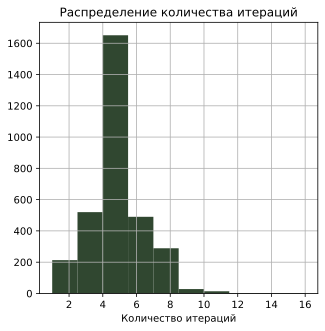

In [8]:
plt.figure(figsize=(5, 5))
counting.hist(bins=10, color = (0.1,0.2,0.1,0.9));
plt.xlabel('Количество итераций')
plt.title('Распределение количества итераций');

In [9]:
# Среднее значение мощностей для кажой партии

mean_real = pd.DataFrame(df_0.groupby('key').mean().real)
mean_real.columns = ['Активная мощность']

mean_reactive = pd.DataFrame(df_0.groupby('key').mean().reactive)
mean_reactive.columns = ['Реактивная мощность']

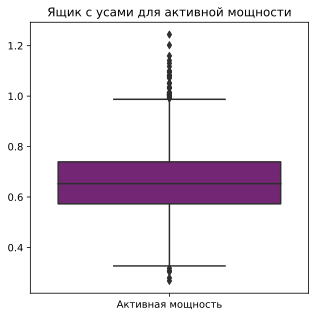

In [10]:
plt.figure(figsize=(5,5))
sns.boxplot(data=mean_real, color = (0.5,0.1,0.5,0.4) );
plt.title('Ящик с усами для активной мощности');

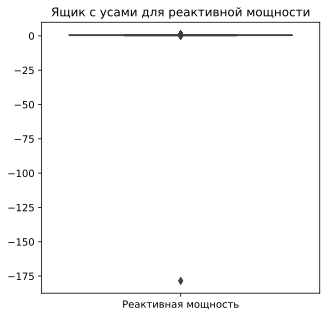

In [11]:
plt.figure(figsize=(5,5))
sns.boxplot(data=mean_reactive);
plt.title('Ящик с усами для реактивной мощности');

In [12]:
# Номер партии, где измерение реактивной мощности отрицательное

df_0.loc[df_0.reactive < 0].index

Int64Index([9780], dtype='int64')

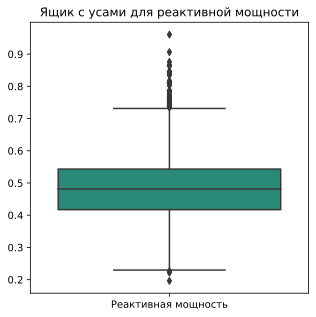

In [13]:
plt.figure(figsize=(5,5))
sns.boxplot(data=mean_reactive[mean_reactive['Реактивная мощность'] > 0], color = (0.1,0.6,0.5,0.6));
plt.title('Ящик с усами для реактивной мощности');

In [14]:
df_0.start_heat[0]

'2019-05-03 11:02:14'

In [15]:
df_0.start_heat.iloc[-1]

'2019-09-06 17:24:54'

**Первый датасет** - это данные об **электродах**. Здесь приведены отсортированные временные ряды за 2019 год, где следят за началом и коцном нагрева дугой, во время чего измеряют активную и реактивную мощности. Cуммарное время измерения - 4 месяца, 4 дня и примерно 5 часов.

Пропусков в данных нет, всего 5 cтолбцов. Проб в совокупности 14876, всего 3241 партия для исследования. 

В среденем, одна партия проходит примерно 5 итераций обработки. Есть партия, где проводилось 16 измерений. С другой стороны, есть партия, где была всего одна итерация. Такую партию можно удалить, так как это - аномалия (должно быть как минимум два замера: начального и конечного).

По графикам ящика с усов для двух мощностей видно, что значения у них распределены одинково. В столбце реактивной мощности есть отрицательное значение - это аномалия в рамках нашего проекта, которую можно удалить.

В целом, из двух столбцов (активная и реактивная мощности) можно получить еще один признак - полная мощность. Затем полную мощность умножить на время нагрева дугой (что можно получить из разности конца и начала нагрева дугой), и получится полная работа. После этого посмотреть на мультиколлинеарность признаков и провести масштабирование.

In [16]:
df_1 = open_df(sets[1], heads[1])

Данные о подаче сыпучих материалов (объём)
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806

None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0



Статистика
------------------------------------------------------------------------------------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
# Среднее значение используемого объема по всем партиям

mean_per = df_1.mean(axis=0).drop(['key']).sort_values(ascending=True)

In [18]:
# Частота использования порошков по всем партиям

count_per = df_1.count(axis=0).drop(['key']).sort_values(ascending=True)

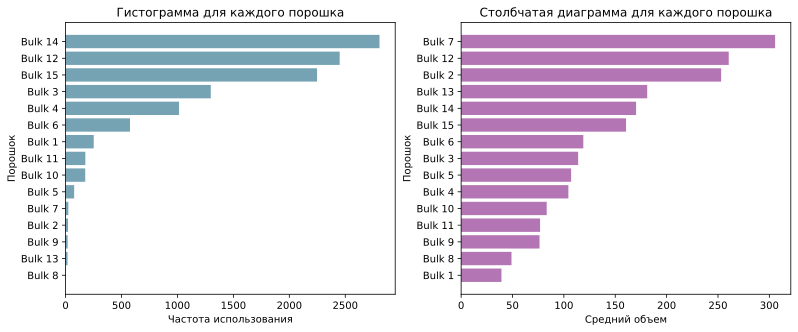

In [19]:
plt.subplot(1, 2, 1)
plt.barh(count_per.index, count_per.values, color = (0.1,0.4,0.5,0.6), );
plt.yticks(count_per.index);
plt.title('Гистограмма для каждого порошка');
plt.xlabel('Частота использования');
plt.ylabel('Порошок');
plt.subplot(1, 2, 2)
plt.barh(mean_per.index, mean_per.values, color = (0.5,0.1,0.5,0.6));
plt.yticks(mean_per.index);
plt.title('Столбчатая диаграмма для каждого порошка');
plt.xlabel('Средний объем');
plt.ylabel('Порошок');

**Второй датасет** - это **объемные данные о подаче сыпучих материалов**. Всего 15 видов. Для каждой партии - свой набор сыпучих материалов, что говорят нам пропуски. Поэтому пропуски можно заменить нулями.

Самый используемый материал - Bulk 14 (в 2806 партиях). Самый большой по объему в среднем - Bulk 7 (305,6). Bulk 8 практически не используется (только 1 раз), а также занимает 2 место среди самых маленьких по объему. Его можно удалить. Bulk 1 хоть в среднем меньше всего по объему, однако добавляется чаще, чем 8 других порошков.

In [20]:
df_2 = open_df(sets[2], heads[2])

Данные о подаче сыпучих материалов (время)
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   obje

None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16



Статистика
------------------------------------------------------------------------------------------------------


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


**Третий датасет** - это **данные о времени, когда добавили сыпучий материал**. Тесно связан со вторым датасетом: пропуски там, где не добавляют сыпучий материал. 

In [21]:
df_3 = open_df(sets[3], heads[3])

Данные о продувке сплава газом
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267



Статистика
------------------------------------------------------------------------------------------------------


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [22]:
#  Переименуем  названия столбцов

df_3 = df_3.rename(columns={'Газ 1':'gas'})

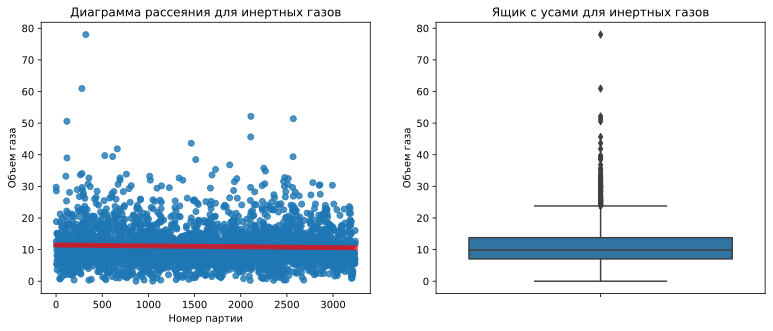

In [23]:
plt.subplot(1, 2, 1);
plt.title('Диаграмма рассеяния для инертных газов');
sns.regplot(x=df_3.key, y=df_3.gas, line_kws={"color":"r","alpha":0.7,"lw":5});
plt.xlabel('Номер партии');
plt.ylabel('Объем газа');

plt.subplot(1, 2, 2);
plt.title('Ящик с усами для инертных газов');
sns.boxplot(y=df_3.gas);
plt.ylabel('Объем газа');

**Четвертый датасет** - это **количество добавляемого инетрного газа**. В среднем добавляют - 11. По графику виден разброс в данных+-10. По второму графику значения выше примерно 26 считаются выбросами. Есть сильный выброс - примерно 78 единиц объема газа. Интересно, что для некоторых партий практичсеки не добавляют инертный газ (к примеру, 0.008399), но таких партий значительно больше, и они находятся в пределах допустимого по графикам. Однако удалять партию с выбросом в 78 единиц не будем, так как, возможно, это норма в рамках технологии производства стали. **Уточнить у заказчика.**

In [24]:
try:
    df_4 = pd.read_csv('data_temp_new.csv')    
except:
    df_4 = pd.read_csv('/datasets/data_temp_new.csv')

In [25]:
df_4[df_4.key == df_3.gas.idxmax()]

,key,Время замера,Температура
1791,319,2019-05-15 17:30:13,1599.0
1792,319,2019-05-15 17:34:19,1582.0
1793,319,2019-05-15 18:02:43,1566.0
1794,319,2019-05-15 18:11:04,1566.0
1795,319,2019-05-15 18:15:22,1564.0
1796,319,2019-05-15 18:25:11,1575.0



При максимальном значении объема газа значение температур в пределах нормы.



In [26]:
df_4 = open_df(sets[4], heads[4])

Результаты измерения температуры
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0



Статистика
------------------------------------------------------------------------------------------------------


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [27]:
#  Переименуем  названия столбцов

df_4 = df_4.rename(columns={'Температура':'temp'})
df_4.rename(columns={'Время замера':'meas_time'}, inplace=True)

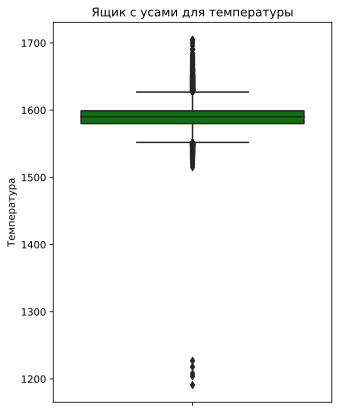

In [28]:
plt.figure(figsize=(5,7))
plt.title('Ящик с усами для температуры');
sns.boxplot(y=df_4.temp, color='green');
plt.ylabel('Температура');

**Пятый датасет** - это **данные об измеренниях температуры**. Столбец с температурой - наш таргет. Необходимо оставить в целевом признаке последнюю температуру, так как после достижения необходимого значения измерения прекращаются. К этим значениям можно оставить первый замер температуры, как фактическую.  
Датасет тесно связан со первым датасетом: температуру измеряют до начала нагревания дугой и после нагрева. Прослеживается четкое среднее значение- около 1590. По всей видимости - это необходимая для фазовых превращений температура.

Заказчик также предупредил о том, что температуры ниже 1500 являеются аномалиями, так как говорят о браке (это подтверждается графиком). При такой температуре сплав железа становится твердым.

Вспомним технологичсекий процесс: 

Перед добавлением легирующих веществ измеряют температуру стали и производят её химический анализ. После добавление проводят еще один замер. Таким образом. можно сделать еще один признак - разница времени между первым измерением температуры и временем, когда добавили сыпучий материал (3 датасет). 

In [29]:
df_5 = open_df(sets[5], heads[5])

Данные о проволочных материалах (объём)
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Статистика
------------------------------------------------------------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
mean_wire = df_5.mean(axis=0).drop(['key']).sort_values(ascending=True)

In [31]:
count_wire = df_5.count().drop(['key']).sort_values(ascending=True)

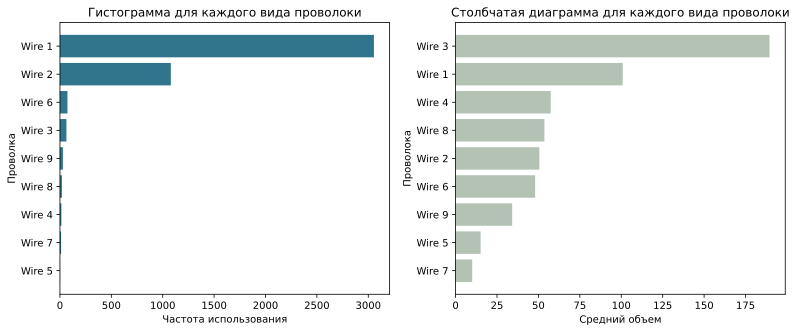

In [32]:
plt.subplot(1, 2, 1)
plt.barh(count_wire.index, count_wire.values, color = (0.1,0.4,0.5,0.9), );
plt.yticks(count_wire.index);
plt.title('Гистограмма для каждого вида проволоки');
plt.xlabel('Частота использования');
plt.ylabel('Проволка');
plt.subplot(1, 2, 2)
plt.barh(mean_wire.index, mean_wire.values, color = (0.5,0.6,0.5,0.6));
plt.yticks(mean_wire.index);
plt.title('Столбчатая диаграмма для каждого вида проволоки');
plt.xlabel('Средний объем');
plt.ylabel('Проволока');

**Шестой датасет** - это **объемные данные о проволоках**. В большинстве случаев используется Wire 1 (3055) и Wire 2. Остальные виды используются на порядок меньше. Меньше всего - Wire 5. (1) По объему выигрывает Wire 3 (189.48). Проигрывает - Wire 7 (10.04). Так как и объем и частота использования Wire 5 крайне малы отсноительно других проволок, это можно считать за аномалию и удалить.

In [33]:
df_6 = open_df(sets[6], heads[6])

Данные о проволочных материалах (время)
------------------------------------------------------------------------------------------------------

Общая информация
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Первые 7 строк
------------------------------------------------------------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Статистика
------------------------------------------------------------------------------------------------------


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


**Седьмой датасет** - это **данные о времени, когда проволока начала участвовать в процесси получения стали**. Тесно связано с шестым датасетом. Поступим также, как с инертным газом: добавим столбец со временем, когда ввели проволоку.

### План работы

По полученным выводам в ходе исследовательского анализа можно выделить следующие этапы работ:
1. В первом датасете найти полную мощность по средним значениям активной и реактивной мощности (корень из квадрата суммы средних значений). Затем определить время измерения и найти полную работу, удалить ее составляющие и столбцы со временем. 
2. Всего 15 видов легирующих порошков. Для каждой партии - свой набор сыпучих материалов, пропуски решено заменить нулями. Bulk 8 будет удален, так как определен как аномалия. Остальные порошки решено не трогать. В датасете о проволоках 9 видов, и решено убрать Wire 5, так как определен тоже как аномалия.
3. Из третьего и седьмого датасетов (где дано время подачи легирующих материалов) по разнице с датасетом, где приведено время измерения, решено сделать еще один признак.
4. Столбец с температурой в соответсвующем датасете - наш таргет. Необходимо оставить в целевом признаке последнюю температуру, так как после достижения необходимого значения измерения прекращаются. К этим значениям можно оставить первый замер температуры, как фактическую. Температуры ниже 1500 являеются аномалиями, так как говорят о браке. Удалим их.
5. Датасет с данными об инертном газе решено не трогать, так как следует с осторожностью удалять вещества, участвующие в технолошических процессах.
6. После того как будут проведены вышеописанные процедуры предобработки данных, датасеты будут объединены по партиям (по столбцу `key`) в один датафрейм с полученными признаками и таргетом. Далее исследование на мультиколлинеарность признаков и масшабирование.
7. Для обучение будет использовать две модели обучения. Простая - линейная регрссия - чтобы также была возможность интрепретировать полученные результаты обучения и веса признаков. Более сложная - LGBM. Выбранная метрика - MAE, чтобы также была возможность для заказчика понять качество модели.
8. В самом конце представить результаты в виде отчета.

## Предобработка данных и сбор признаков

### Предобработка

Выполним предобработку данных, исходя из намеченного плана.

Основная предобработка, которая затронет и обучающую, и тестовую выборки - это удаление аномалий.

In [34]:
# Удалим выброс в реактивной мощности

df_0.drop(index=df_0.loc[df_0.reactive < 0].index, inplace=True)

In [35]:
#к.р
keys_1500 = df_4[df_4['temp']<1500].key.values
keys_1500

array([ 867, 1214, 1619, 2052, 2561], dtype=int64)

In [36]:
# Посчитаем и удалим партии, где температура оказалась меньше 1500

print('Количество удаленных измерений температур, где в партии было измерение меньше 1500 градусов: ', df_4.query('key in @keys_1500').count()[0])

df_4 = df_4.query('key not in @keys_1500')

Количество удаленных измерений температур, где в партии было измерение меньше 1500 градусов:  27


In [37]:
#к.р.
df_4[df_4['key']==867]

,key,meas_time,temp


In [38]:
def first_set(df):
    
    # Приведем к типу данных datetime, чтобы вычислить разницу между началом и концом нагрева
    df[['start_heat', 'end_heat']] = df[['start_heat', 'end_heat']].apply(pd.to_datetime)

    # Найдем время измерения
    df['heat_time'] = (df.end_heat - df.start_heat) / np.timedelta64 ( 1 , 's')
    
    
    df = df.groupby('key').mean()
    
    #  Новый признак - полная мощность
    df['power'] = df.apply(lambda x: (x.real**2 + x.reactive**2)**0.5, axis=1)
    df['work'] = df['power'] * df['heat_time']
    
    return df

In [39]:
def fifth_set(df):
    
# Удалим партии в пятом датасете, где меньше двух измерений
    
    count_temp = df.groupby('key').count().temp
    count_temp = count_temp[count_temp > 1].index
    df = df.query('key in @count_temp')

# Удалим промежуточные измерения
    
    # Последние измерения внутри одной партии
    df['meas_time'] = df['meas_time'].apply(pd.to_datetime)
    last = df.groupby('key')['meas_time'].apply(lambda x: x. nlargest (1))
    ind_last = [i[1] for i in list(last.index)]
    
    # Первые измерения внутри одной партии
    fisrt = df.groupby('key')['meas_time'].apply(lambda x: x. nsmallest (1))
    ind_fisrt = [i[1] for i in list(fisrt.index)]
    ind = [j for i in [ind_last, ind_fisrt] for j in i] 
    
    ind.sort()
    df = df.query('index in @ind')

# Удалим пропуски в последних замерах
    
    # Выведем ранжированный внутри партий стобец по времени измерения (первое и последнее измерение)
    df['rank'] = df.groupby('key')['meas_time'].rank()

    #  Удалим партии, где есть пропуски среди последних замеров
    miss = df[(df['rank'] ==2) & (df['temp'].isna())].key
    df = df.query('key not in @miss')
    
# Добавление новых признаков: последний замер и первый замер
    
    df_new = df[df['rank']==2][['key', 'temp']].reset_index(drop=True)
    fisrt_temp =  df[df['rank']==1]['temp'].reset_index(drop=True)
    df_new['fisrt_temp'] = fisrt_temp
        
    return df_new

### Оформление признаков в единый датасет

In [40]:
def combine_sets(mass):
#     Обработали отдельно первый и пятый датасеты
    mass[0] = first_set(mass[0])
    mass[3]= fifth_set(mass[3])
#     Выделили номера партий в качестве индексов для соединения
    for df in mass:
        if 'key' in df.columns:
            df.set_index('key', inplace=True)
#     Объединение
    df_fin = pd.concat(mass, axis=1, join='inner')    
#      Аномальные столбцы
    df_fin.drop(['Bulk 8', 'Wire 5'], axis=1, inplace=True)
#     Пропуски
    df_fin.fillna(0, inplace=True)
#     Доп. признак
    df_fin['key'] = df_fin.index
    return *mass, df_fin

In [41]:
sets = [df_0, df_1, df_3, df_4, df_5]

In [42]:
df_0, df_1, df_3, df_4, df_5, final = combine_sets(sets)

In [43]:
final.head()

,real,reactive,heat_time,power,work,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,fisrt_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,key
key,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743328,163.234817,0.0,0.0,0.0,43.0,0.0,...,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.534852,0.363339,202.75,0.646593,131.096663,0.0,0.0,0.0,73.0,0.0,...,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.812728,0.587491,131.00,1.002833,131.371074,0.0,0.0,0.0,34.0,0.0,...,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.676622,0.514248,185.25,0.849864,157.437290,0.0,0.0,0.0,81.0,0.0,...,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.563238,0.421998,217.25,0.703789,152.898103,0.0,0.0,0.0,78.0,0.0,...,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5


In [44]:
df = [df_0, df_1, df_2, df_3, df_4, df_5, df_6]
print('Было партий до предобработки: 3241' )
print('Количество оставшихся в ходе обработок аномалий, выбросов и группировок партий в датасетах:')
print()
for i in range(len(df)):
    if i == 2 or i==6:
        print(f'Датасет {i+1} не используется')
    else: 
        print(f'В датасете {i+1}: {df[i].shape[0]}')
print('Сколько строк в финальном датасете: ', final.shape[0])

Было партий до предобработки: 3241
Количество оставшихся в ходе обработок аномалий, выбросов и группировок партий в датасетах:

В датасете 1: 3214
В датасете 2: 3129
Датасет 3 не используется
В датасете 4: 3239
В датасете 5: 2471
В датасете 6: 3081
Датасет 7 не используется
Сколько строк в финальном датасете:  2325


In [45]:
# Общая информация о финальном датасете

final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   real        2325 non-null   float64
 1   reactive    2325 non-null   float64
 2   heat_time   2325 non-null   float64
 3   power       2325 non-null   float64
 4   work        2325 non-null   float64
 5   Bulk 1      2325 non-null   float64
 6   Bulk 2      2325 non-null   float64
 7   Bulk 3      2325 non-null   float64
 8   Bulk 4      2325 non-null   float64
 9   Bulk 5      2325 non-null   float64
 10  Bulk 6      2325 non-null   float64
 11  Bulk 7      2325 non-null   float64
 12  Bulk 9      2325 non-null   float64
 13  Bulk 10     2325 non-null   float64
 14  Bulk 11     2325 non-null   float64
 15  Bulk 12     2325 non-null   float64
 16  Bulk 13     2325 non-null   float64
 17  Bulk 14     2325 non-null   float64
 18  Bulk 15     2325 non-null   float64
 19  gas         2325 non-null  

В итоге всего 26 признаков и 2329 объекта.

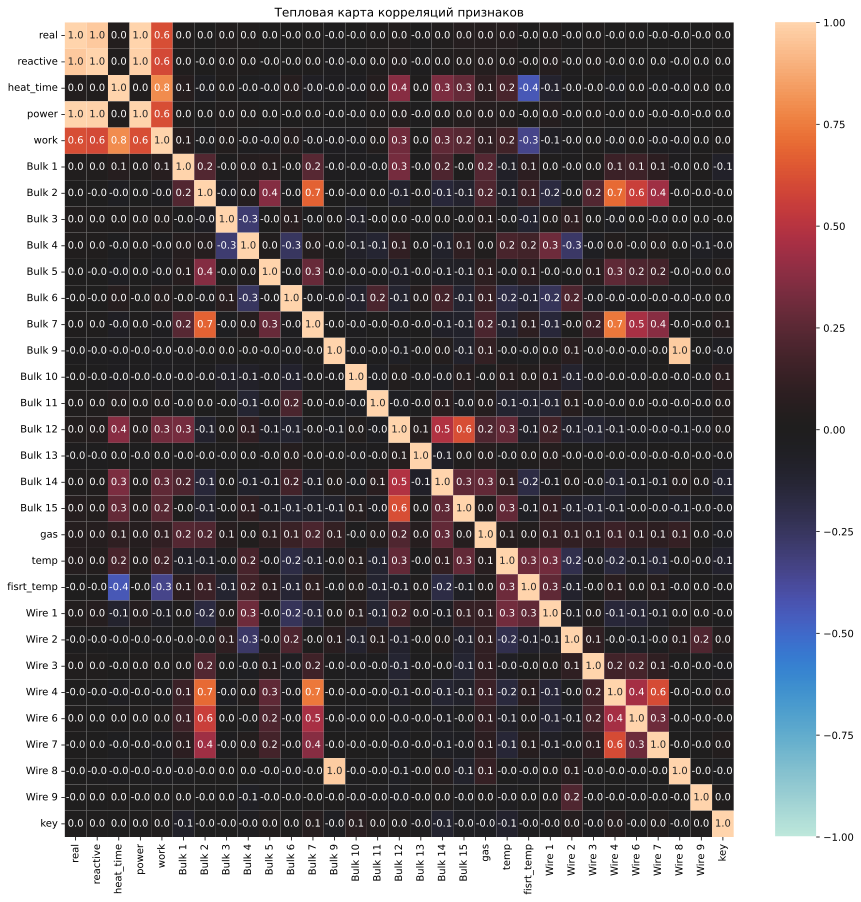

In [46]:
plt.figure(figsize=(15, 15))
plt.title('Тепловая карта корреляций признаков');
sns.heatmap(final.corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1f');

По тепловой карте видны участки положительной и отрицательной корреляции. Исследуем их подробнее. 

Видно, что целевой признак - финальная температура - ни с кем не коррелирует.

Полная корреляция Wire 8 и Bulk 9. Удалять коррелирующие признаки не будем, так как это может повлиять на линейную регрессию. 

## Обучение

### Разделение на обучающую и тестовую выборки

In [47]:
random = 60623

In [48]:
final.head()

,real,reactive,heat_time,power,work,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,fisrt_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,key
key,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743328,163.234817,0.0,0.0,0.0,43.0,0.0,...,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.534852,0.363339,202.75,0.646593,131.096663,0.0,0.0,0.0,73.0,0.0,...,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.812728,0.587491,131.00,1.002833,131.371074,0.0,0.0,0.0,34.0,0.0,...,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.676622,0.514248,185.25,0.849864,157.437290,0.0,0.0,0.0,81.0,0.0,...,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.563238,0.421998,217.25,0.703789,152.898103,0.0,0.0,0.0,78.0,0.0,...,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5


In [49]:
features = final.drop(['temp'], axis=1)
target = final.temp

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            random_state=random, 
                                                                            test_size=0.25
                                                                            )

In [51]:
features_train.shape

(1743, 30)

In [52]:
target_test.shape

(582,)

### Линейная регрессия

In [53]:
lin = LinearRegression(n_jobs=-1)
model_lin = make_pipeline(StandardScaler(), lin)
lin_res = cross_validate(model_lin, 
                         features_train, 
                         target_train, 
                         n_jobs=-1, 
                         scoring='neg_mean_absolute_error', 
                         cv=4
                         )
lin_res = round(lin_res['test_score'].mean()*-1, 3)
print('Среднее значение метрики MAE для линейной регресии:', lin_res)

Среднее значение метрики MAE для линейной регресии: 6.766


### Линейная регрессия с регулизацией

In [54]:
model_regL2 = Ridge(random_state=random)
model_reg = make_pipeline(StandardScaler(), model_regL2)
param_grid = {'ridge__alpha': np.arange(0.01, 1, 0.1)}
reg = GridSearchCV(model_reg, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=3)
reg.fit(features_train, target_train)
mae_regL2 = round(reg.best_score_ * -1, 3)
print('Значение MAE для линейной регрессии с регуляризацией L2 :', mae_regL2)

Значение MAE для линейной регрессии с регуляризацией L2 : 6.817


### LGBM

In [55]:
model_lgb = LGBMRegressor(random_state=random, n_jobs=-1)

param_grid_lgb = {
                  'num_leaves': [5, 10, 30, 50],
                  'learning_rate': [0.1, 0.3, 0.5, 1.0],
                  'max_depth': [3, 5, 10, 15, 20],
                  'n_estimators': [10, 25, 50, 75]}
                 
rs_lgb = GridSearchCV(model_lgb, 
                            param_grid=param_grid_lgb, 
                            n_jobs=-1, 
                            scoring='neg_mean_absolute_error',
                            cv=3
                           )
rs_lgb.fit(features_train, target_train)

mae_lgb = rs_lgb.best_score_ * -1
print('Значение MAE для LGBM :', mae_lgb)
print(rs_lgb.best_params_)

Значение MAE для LGBM : 6.5869931648912745
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75, 'num_leaves': 5}


### CatBoost

In [56]:
model_cat = CatBoostRegressor(random_state=random, loss_function="MAE")

grid = {'depth': [4, 6, 10]}

model_cat.grid_search(grid, X=features_train, y=target_train, cv=3)

0:	learn: 1545.0304592	test: 1546.0487680	best: 1546.0487680 (0)	total: 142ms	remaining: 2m 21s
1:	learn: 1498.7099402	test: 1499.7225347	best: 1499.7225347 (1)	total: 143ms	remaining: 1m 11s
2:	learn: 1453.7775655	test: 1454.7919900	best: 1454.7919900 (2)	total: 143ms	remaining: 47.6s
3:	learn: 1410.1826511	test: 1411.1960434	best: 1411.1960434 (3)	total: 144ms	remaining: 35.9s
4:	learn: 1367.9019307	test: 1368.9140089	best: 1368.9140089 (4)	total: 145ms	remaining: 28.8s
5:	learn: 1326.8902971	test: 1327.9020715	best: 1327.9020715 (5)	total: 146ms	remaining: 24.1s
6:	learn: 1287.1172632	test: 1288.3524663	best: 1288.3524663 (6)	total: 146ms	remaining: 20.7s
7:	learn: 1248.5327721	test: 1249.7596361	best: 1249.7596361 (7)	total: 147ms	remaining: 18.3s
8:	learn: 1211.0976938	test: 1212.3288799	best: 1212.3288799 (8)	total: 148ms	remaining: 16.3s
9:	learn: 1174.7894877	test: 1176.0152804	best: 1176.0152804 (9)	total: 149ms	remaining: 14.8s
10:	learn: 1139.5712130	test: 1140.7962235	best:

{'params': {'depth': 4},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
       

In [57]:
mae_cat = model_cat.best_score_['learn']['MAE']
print('Значение MAE на обучающей выборке для CatBoost :', mae_cat)

Значение MAE на обучающей выборке для CatBoost : 4.646122941095309


### Результаты обучения

In [58]:
results = pd.DataFrame([lin_res, mae_regL2, mae_lgb, mae_cat],

    index=['LinearRegression', 'Ridge', 'LGBM', 'CatBoost'], 
    columns=['MAE на обучающей выборке'] 
)
results

,MAE на обучающей выборке
LinearRegression,6.766000
Ridge,6.817000
LGBM,6.586993
CatBoost,4.646123


In [59]:
min_res = results['MAE на обучающей выборке'].min()

In [60]:
print(f'Лучшее значение метрики MAE {round(min_res,2)} у {results.idxmin()[0]}')

Лучшее значение метрики MAE 4.65 у CatBoost


## Тест

In [61]:
pred = model_cat.predict(features_test)

In [62]:
res = mean_absolute_error(target_test, pred) 

In [63]:
if res <= 6.8:
    print('Таким образом, мы достигли необходимого значения метрики MAE: ', round(res, 2))

Таким образом, мы достигли необходимого значения метрики MAE:  6.77


## Важность признаков

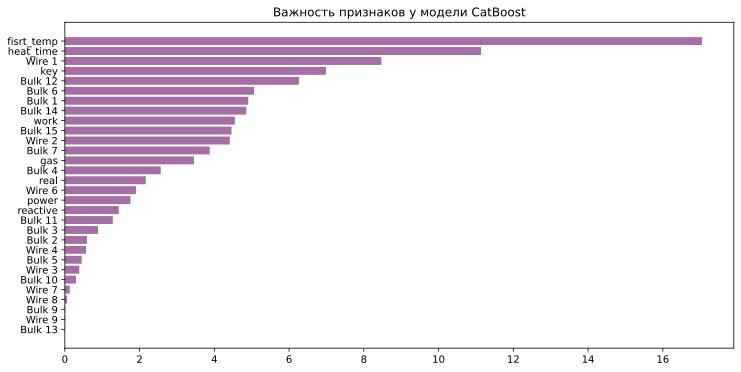

In [64]:
feature_importance = model_cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = (0.5,0.2,0.5,0.7));
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx]);
plt.title('Важность признаков у модели CatBoost');

На первое место вышла начальная температура сплава, что неудивительно.

Далее идет время нагрева - чем дольше греешь, тем выше будет температура. 

Интересно, что мощность не сыграла сильной роли: в приоритете все-таки время нагрева.

Также наблюдательно, что в топ-3 попал номер партии, что говорит нам о "неравномерности" условий измерения и технологического процесса.

Далее идут легирующие добавки и инертный газ: что-то влияет на температуру ('Bulk 14', 'Wire 2', 'Bulk 1', 'Bulk 6', 'Bulk 12', 'Wire 1'), что-то вообще нет ('Bulk 9', 'Wire 9', 'Bulk 2', 'Bulk 13', 'Wire 7'). 

## Выводы

Сделаем промежуточные выводы после предобработки, обучения и теста.

1. До предобработки была 3241 партия. После удаления аномалий в реактивной мощности, в измеренных температурах, удаление единичных измерений, преобразований стобцов для новых признаков получилось 2329 партий.
2. Появились новые признаки: полная мощность и работа, время нагревания, номер партии. Всего признаков 26 после исследования на корреляцию (удалили Wire 8)
3. Обучено 4 модели: линейные регрессии и бустринги. Лучше всего себя показал CatBoost c значением на тестовой выборке 6.56